In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, IBMQ
from qiskit.circuit.library import PhaseGate, ExactReciprocal
from qiskit.extensions import UnitaryGate, HamiltonianGate
import qiskit_tools as qt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [2]:
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
width=0.75
color='black'
fontsize=28
ticksize=22
figsize=(10,8)

In [3]:
def HHL_itt(circ, qreg, qanc, qtarg, A_gate, scaling=1., wrap=False, inverse=False, label='HHL'):
    
    n = len(qreg)
    nanc = len(qanc)

    if inverse:
        wrap = True

    if wrap:
        qreg = QuantumRegister(n, 'q_reg')
        qanc = QuantumRegister(nanc, 'q_anc')
        qtarg = QuantumRegister(1, 'q_targ')
        circ = QuantumCircuit(qreg, qanc, qtarg)

    qe_gate = qt.PhaseEst(circ, qreg, qanc, A_gate, wrap=True)
    circ.append(qe_gate, [*qreg, *qanc]);
    
    rec_gate = ExactReciprocal(nanc, scaling=scaling)
    circ.append(rec_gate, [*qanc, qtarg]);

    qe_gate_inv = qt.PhaseEst(circ, qreg, qanc, A_gate, wrap=True, inverse=True)
    circ.append(qe_gate_inv, [*qreg, *qanc]);
    
    if wrap:
        circ = circ.to_gate()
        circ.label = label

    if inverse:
        circ = circ.inverse()
        circ.label = label+'\dag'

    return circ

In [4]:
def HHL(circ, qreg, qanc, qtarg, ctarg, A_gate, scaling=1., wrap=False, inverse=False, label='HHL'):
    
    n = len(qreg)
    nanc = len(qanc)

    if inverse:
        wrap = True

    if wrap:
        qreg = QuantumRegister(n, 'q_reg')
        qanc = QuantumRegister(nanc, 'q_anc')
        qtarg = QuantumRegister(1, 'q_targ')
        ctarg = ClassicalRegister(1, 'c_targ')
        circ = QuantumCircuit(qreg, qanc, qtarg, ctarg)

    with circ.while_loop((ctarg, 1)):
        HHL_gate = HHL_itt(circ, qreg, qanc, qtarg, A_gate, scaling=scaling, wrap=True)
        circ.append(HHL_gate, [*qreg, *qanc, qtarg]);
        
        circ.measure(qtarg, ctarg)
    
    if wrap:
        circ = circ.to_gate()
        circ.label = label

    if inverse:
        circ = circ.inverse()
        circ.label = label+'\dag'

    return circ

In [5]:
matrix = np.array([[1., -1./3], [-1./3, 1.]])
t = 2*np.pi*3./8.
A_gate = HamiltonianGate(matrix, t)

In [6]:
n = 1
nanc = 2

In [7]:
qreg = QuantumRegister(n, 'q_reg')
qanc = QuantumRegister(nanc, 'q_anc')
qtarg = QuantumRegister(1, 'q_targ')
#canc = ClassicalRegister(nanc, 'c_targ')
#ctarg = ClassicalRegister(1, 'c_targ')
circ = QuantumCircuit(qreg, qanc, qtarg)#, ctarg, cnanc)

In [8]:
circ = HHL_itt(circ, qreg, qanc, qtarg, A_gate, scaling=1./8)

In [9]:
backend = Aer.get_backend('statevector_simulator')
job = execute(circ, backend)
result = job.result()
state_vector = np.asarray(result.get_statevector())

In [10]:
state_v = np.asarray(state_vector).reshape((2**1,2**nanc,2**n)).T

In [11]:
print(np.sum(np.abs(state_v[0])**2),np.sum(np.abs(state_v[1])**2))
print(5./32)
print(np.sum(np.abs(state_v[0])**2)+np.sum(np.abs(state_v[1])**2))

0.979298402792265 0.020701597207730613
0.15625
0.9999999999999956


In [12]:
# Measure and renormalize
state_v = state_v[0]/np.sqrt(np.sum(np.abs(state_v[0])**2))

In [13]:
print(np.sum(np.abs(state_v)**2))

0.9999999999999999


In [14]:
# targ, nanc, n
print(state_v.shape)

(4, 2)


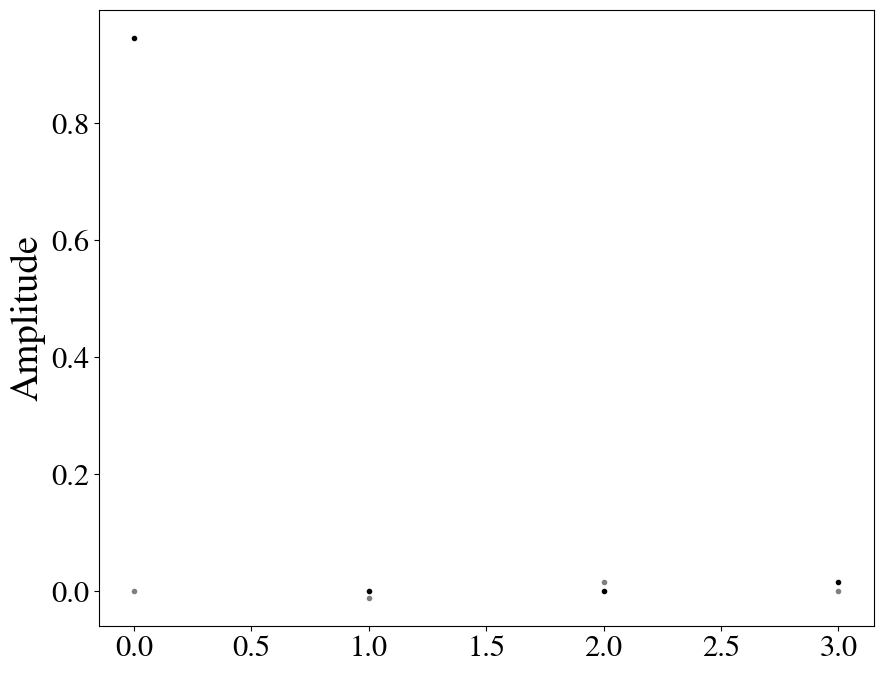

In [15]:
fig = plt.figure(figsize=figsize)
ax = fig.gca()

plt.scatter(np.arange(2**nanc), state_v[:,0].real, marker='.', color='black')
plt.scatter(np.arange(2**nanc), state_v[:,0].imag, marker='.', color='grey')
ax.set_ylabel('Amplitude', fontsize=fontsize);
ax.tick_params(axis='both', labelsize=ticksize);

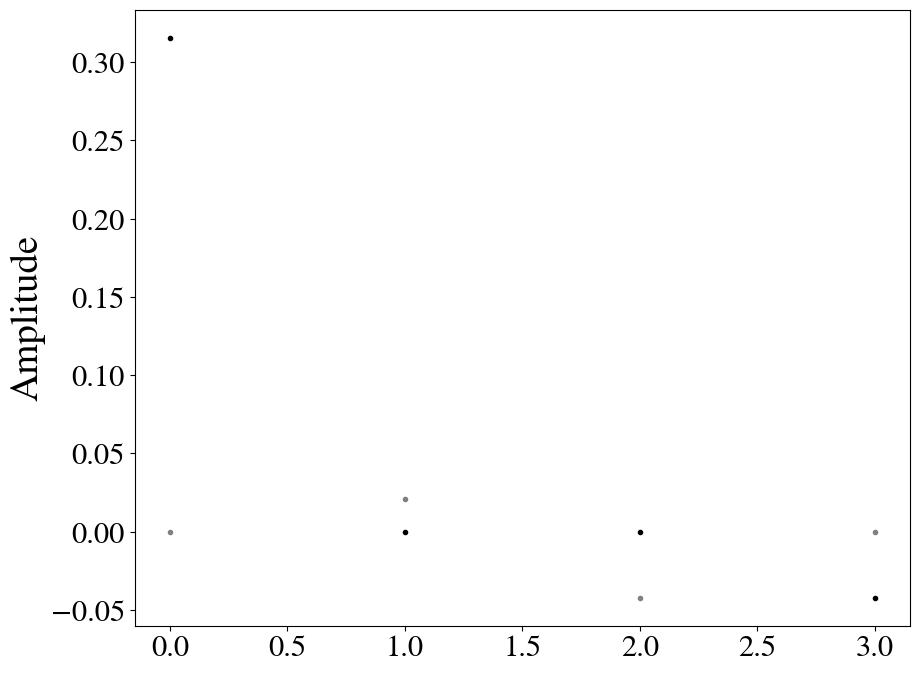

In [16]:
fig = plt.figure(figsize=figsize)
ax = fig.gca()

plt.scatter(np.arange(2**nanc), state_v[:,1].real, marker='.', color='black')
plt.scatter(np.arange(2**nanc), state_v[:,1].imag, marker='.', color='grey')
ax.set_ylabel('Amplitude', fontsize=fontsize);
ax.tick_params(axis='both', labelsize=ticksize);